En este notebook generaremos las explicaciones con LIME para los siguientes modelos, en el orden que se detalla a continuación:

1. Denzel Washington

2. Lola Lolita

3. Modelo KNN

4. Modelo MLP

Importamos las librerías necesarias.

In [6]:
from sklearn.metrics import *
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.init as init
import importlib
import data
import agente_cnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import agente_knn
import agente_mlp
from torchvision.transforms import ToPILImage
from lime import lime_image
from PIL import Image
from skimage.segmentation import mark_boundaries
from sklearn.neighbors import KNeighborsClassifier

importlib.reload(data)
importlib.reload(agente_cnn)
importlib.reload(agente_knn)
importlib.reload(agente_mlp)

<module 'agente_mlp' from 'd:\\Universidad\\Aprendizaje-Automatico-y-Big-Data\\Practica5\\agente_mlp.py'>

Definimos algunas variables que serán posteriormente utilizadas:

In [7]:
path = "./UTKFace"
idx = 100
GENERO = ('Hombre','Mujer')
RAZA = ('Blanco','Negro','Asiático','Indio','Otros')

Transformamos las imágenes aplicando normalización y las convertimos a tensores para adaptarlas al dataset. A continuación, extraemos una imagen junto con sus etiquetas (edad, género y raza), revertimos la normalización para visualizarla correctamente y la mostramos con su información asociada.

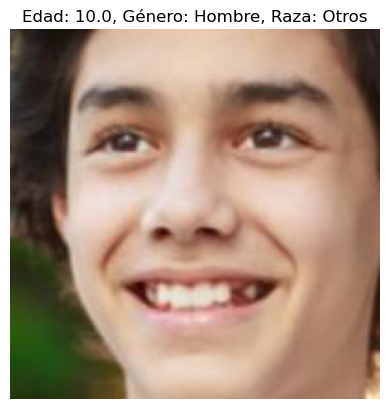

In [8]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = data.Dataset(path, transform=transform)  # Pasamos las imagenes a la estructura de datos
imagen, age,gender,race = dataset.__getitem__(idx)
imagen_np = imagen.permute(1, 2, 0).numpy()  # Convertir (C, H, W) a (H, W, C)

imagen_np = imagen_np * 0.5 + 0.5  # Revertir la normalización


plt.imshow(imagen_np)
plt.title(f"Edad: {age}, Género: {GENERO[gender]}, Raza: {RAZA[race]}")  
plt.axis('off') 
plt.show()

Se trata de un niño de 10 años con raza no especificada. Esta instancia será utilizada para la explicación con LIME, donde resaltaremos las características más relevantes que cada modelo considera al tomar una decisión en cada categoría.

Definimos el modelo 3 de nuevo y lo cargamos.

In [8]:
class DenzelWashington(nn.Module):
    def __init__(self,output_layers):
        super().__init__()

        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.pool2 = nn.MaxPool2d(4, 4)
       
        self.fc1 = nn.Linear(12 * 11 * 11, 500)
        self.fcout = nn.Linear(500, output_layers)

        self.apply(self._init_weights)  # Aplicar la inicialización de pesos

    def _init_weights(self, m):
        """Inicializa los pesos de la red"""
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None:
                init.constant_(m.bias, 0)

    def forward(self, x):

        x = self.pool1(x) #3 fotos 100x100
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.fcout(x)
        return x


#Modelo edad
DWEdad = DenzelWashington(output_layers=1)
mseLoss = nn.MSELoss()

#Modelo Genero
DWGenero = DenzelWashington(output_layers=2)
entropyLossGen = nn.CrossEntropyLoss()

#Modelo raza
DWRaza = DenzelWashington(output_layers=5)
entropyLossRaza = nn.CrossEntropyLoss()

agenteDW = agente_cnn.Agente(modeloEdad=DWEdad,
                         modeloGenero=DWGenero,
                         modeloRaza=DWRaza,
                         criterioEdad=mseLoss,
                         criterioGenero=entropyLossGen,
                         criterioRaza=entropyLossRaza,
                         device="cpu",
                         lr = 0.0001)

agenteDW.modeloEdad.load_state_dict(torch.load('./Modelos/DWEdad.pth',map_location=torch.device('cpu')))
agenteDW.modeloGenero.load_state_dict(torch.load('./Modelos/DWGenero.pth',map_location=torch.device('cpu')))
agenteDW.modeloRaza.load_state_dict(torch.load('./Modelos/DWRaza.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [5]:
device = "cpu"

Definimos el modelo 4 de nuevo y lo cargamos.

In [4]:
class LolaLolita(nn.Module):
    def __init__(self,output_layers):
        super().__init__()

        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(6, 12, 4)
        self.conv3 = nn.Conv2d(12,24,6)
        self.conv4 =  nn.Conv2d(24,48,16)
        self.pool2 = nn.MaxPool2d(3, 3)
       
        self.fc1 = nn.Linear(48 * 100, 1200)
        self.fc2 = nn.Linear(1200, 850)
        self.fcout = nn.Linear(850, output_layers)

        self.apply(self._init_weights)  # Aplicar la inicialización de pesos

    def _init_weights(self, m):
        """Inicializa los pesos de la red"""
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None:
                init.constant_(m.bias, 0)

    def forward(self, x):

        x = self.pool1(x) 
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(F.relu(self.conv3(x)))
        x = self.pool2(F.relu(self.conv4(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fcout(x)
        return x
    
#Modelo edad
LLEdad = LolaLolita(output_layers=1)
mseLoss = nn.MSELoss()

#Modelo Genero
LLGenero = LolaLolita(output_layers=2)
entropyLossGen = nn.CrossEntropyLoss()

#Modelo raza
LLRaza = LolaLolita(output_layers=5)
entropyLossRaza = nn.CrossEntropyLoss()

agenteLL= agente_cnn.Agente(modeloEdad=LLEdad,
                         modeloGenero=LLGenero,
                         modeloRaza=LLRaza,
                         criterioEdad=mseLoss,
                         criterioGenero=entropyLossGen,
                         criterioRaza=entropyLossRaza,
                         device="cpu",
                         lr = 0.00001)
agenteLL.modeloEdad.load_state_dict(torch.load('./Modelos/LLEdad.pth',map_location=torch.device('cpu')))
agenteLL.modeloGenero.load_state_dict(torch.load('./Modelos/LLGenero.pth',map_location=torch.device('cpu')))
agenteLL.modeloRaza.load_state_dict(torch.load('./Modelos/LLRaza.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

Volvemos a cargar y entrenar el modelo KNN, ya que, debido al uso de memoria que implica, no fue posible guardarlo en el notebook "modelos" para su posterior carga en este. Por ello, optamos por esta alternativa, dado que su entrenamiento no requiere mucho tiempo de ejecución.

In [9]:
# Creamos el dataset y los dataloaders
train_dataloader, _ = data.entrenamientoTest(dataset=dataset, test_size=0.2, batch_size=1)

In [10]:
X_train, Y_train = data.cargarDatos(train_dataloader, num_imagenes=len(train_dataloader), categoria="genero") 
MbappeGenero= KNeighborsClassifier(n_neighbors=9)
MbappeGenero.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=9)

In [11]:
X_train, Y_train = data.cargarDatos(train_dataloader, num_imagenes=len(train_dataloader), categoria="raza")

MbappeRaza= KNeighborsClassifier(n_neighbors=7)
MbappeRaza.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=7)

In [12]:
X_train, Y_train = data.cargarDatos(train_dataloader, num_imagenes=len(train_dataloader), categoria="edad") 
MbappeEdad= KNeighborsClassifier(n_neighbors=7)
MbappeEdad.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=7)

Definimos de nuevo y cargamos el modelo MLP.

In [6]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        # Definir las capas del MLP
        self.fc1 = nn.Linear(input_size, 512)  # Capa de entrada -> 512 unidades
        self.fc2 = nn.Linear(512, 256)         # Capa oculta -> 256 unidades
        self.fc3 = nn.Linear(256, num_classes) # Capa de salida -> número de clases

    def forward(self, x):
        # Aplanar las imágenes de tamaño (batch_size, 3, 64, 64) a (batch_size, 12288)
        x = x.view(x.size(0), -1)  # Aplanar las imágenes a un vector 1D por imagen
        x = F.relu(self.fc1(x))    # Capa 1 -> ReLU
        x = F.relu(self.fc2(x))    # Capa 2 -> ReLU
        x = self.fc3(x)            # Capa 3 -> Salida
        return x
    

mlp_raza = MLP(input_size=64*64*3, num_classes=5)
mlp_raza.load_state_dict(torch.load('./Modelos/NapoleonRaza.pth'))
mlp_raza.eval()  # Para ponerlo en modo evaluación
mlp_edad = MLP(input_size=64*64*3, num_classes=10)
mlp_edad.load_state_dict(torch.load('./Modelos/NapoleonEdad.pth'))
mlp_edad.eval()  # Para ponerlo en modo evaluación
mlp_genero = MLP(input_size=64*64*3, num_classes=2)
mlp_genero.load_state_dict(torch.load('./Modelos/NapoleonGenero.pth'))
mlp_genero.eval()  # Para ponerlo en modo evaluación

MLP(
  (fc1): Linear(in_features=12288, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)

Una vez que hemos definido y cargado los modelos, procedemos a generar la explicación utilizando LIME.


## Modelo : LIME

Utilizaremos el modelo LIME para generar las explicaciones correspondientes para cada uno de los modelos definidos anteriormente.

En esta función realizamos una predicción: procesamos la imagen, la convertimos en tensor, la normalizamos y la pasamos por un modelo para hacer predicciones. Dependiendo del tipo de tarea (classification o regression), devolvemos el índice de la clase con mayor probabilidad (en clasificación) o el valor continuo predicho (en regresión).

In [9]:
def predict(imagen, modelo, device, transform=None, task_type='classification'):
    modelo.eval()

    # Si la imagen es un tensor, la usamos directamente; si es PIL, la transformamos
    if isinstance(imagen, torch.Tensor):
        img_tensor = imagen.unsqueeze(0).to(device)
    else:
        if transform is None:
            transform = transforms.Compose([
                transforms.Resize((100, 100)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
            ])
        img_tensor = transform(imagen).unsqueeze(0).to(device)

    with torch.no_grad():
        salida = modelo(img_tensor)  # Obtenemos la salida del modelo

        # Si es un modelo de clasificación (como género o raza), usamos softmax para obtener las probabilidades
        if task_type == 'classification':
            probs = F.softmax(salida, dim=1).cpu().numpy()[0]  # Obtenemos las probabilidades
            clase_idx = probs.argmax()  # Obtenemos el índice de la clase con mayor probabilidad
            return clase_idx  # Devolvemos el índice de la clase

        # Si es un modelo de regresión (como edad), devolvemos el valor predicho directamente
        elif task_type == 'regression':
            return salida.cpu().numpy()[0]  # Devolvemos la predicción continua (edad)



Esta función genera una explicación LIME para un modelo de clasificación o regresión aplicado a imágenes. Convierte la imagen en un formato adecuado para el modelo, define la función de predicción para LIME (según el tipo de tarea: clasificación o regresión), y luego utiliza el explicador LIME para resaltar las características más importantes para la predicción. Finalmente, muestra la imagen original y la explicación LIME de forma visual.

In [ ]:
def lime_explanation(imagen_original, imagen_lime, modelo, device, transform, task_type='classification', num_features=5, num_samples=1000):
    # Nos aseguramos de que imagen_lime sea PIL
    if isinstance(imagen_lime, torch.Tensor):
        imagen_lime = ToPILImage()(imagen_lime.cpu())
    img_np = np.array(imagen_lime)  # Convertir a NumPy array

    # Función de predicción para LIME
    def predict_fn(images):
        modelo.eval()
        inputs = [transform(Image.fromarray(img)).unsqueeze(0).to(device) for img in images]
        inputs = torch.cat(inputs)
        with torch.no_grad():
            outputs = modelo(inputs)

            # Si es un modelo de clasificación, aplicamos softmax para obtener las probabilidades
            if task_type == 'classification':
                probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
                return probs
            # Si es un modelo de regresión, simplemente devolvemos la salida
            elif task_type == 'regression':
                return outputs.cpu().numpy()

    # Creamos el explicador y generar la explicación
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image=img_np,
        classifier_fn=predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=num_samples
    )

    # Obtenemos la imagen explicada
    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0] if task_type == 'classification' else 0,  # Si es regresión, solo se usa un label
        positive_only=True,
        hide_rest=False,
        num_features=num_features,
        min_weight=0.0
    )

    # Visualización: imagen original y explicación lado a lado
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(imagen_original)
    ax[0].axis('off')
    ax[0].set_title('Imagen original')

    ax[1].imshow(mark_boundaries(temp / 255.0, mask))
    ax[1].axis('off')
    ax[1].set_title('Explicación LIME')

    plt.tight_layout()
    plt.show()

    return explanation


### 1. Modelo Denzel Washington

En este apartado generaremos las explicaciones correspondientes para cada categoría dado este modelo basado en una red convolucional.

Para el modelo definido para predecir el género, analizamos la predicción y comprobamos que es correcta, ya que identifica el género masculino.

In [14]:
clase = predict(imagen, modelo=agenteDW.modeloGenero, device="cpu",task_type="classification")
print ('La prediccion es la clase: ', GENERO[clase])

La prediccion es la clase:  Hombre


Generamos la explicación del modelo 1 en la categoría de género utilizando la instancia anteriormente descrita.

100%|██████████| 1000/1000 [00:03<00:00, 312.79it/s]


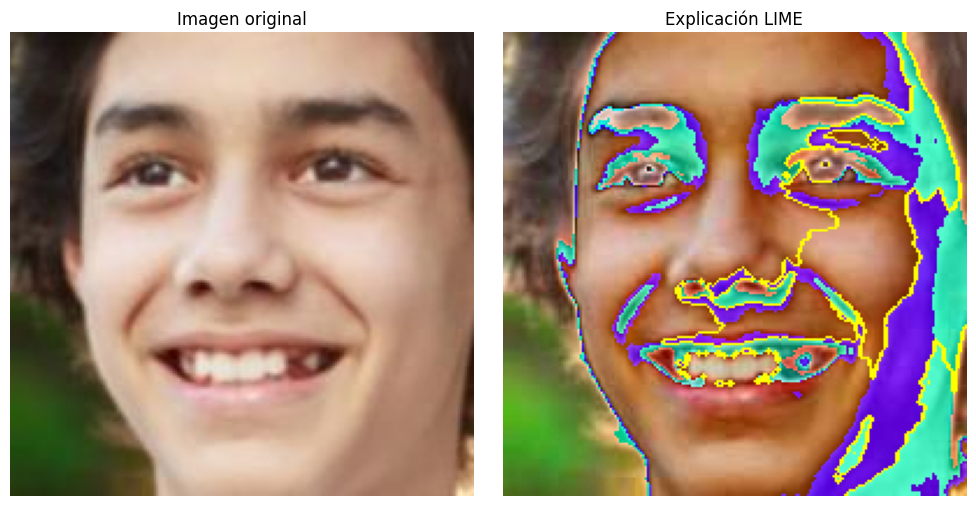

In [12]:
lime_explanation(
    imagen_original=imagen_np,              # Imagen original en formato numpy (H, W, C)
    imagen_lime=imagen,                     # Imagen a explicar (puede ser un tensor o PIL)
    modelo=agenteDW.modeloGenero,            # Modelo a utilizar (en este caso, el modelo de género)
    device=device,                          # Dispositivo donde se encuentra el modelo (cpu o cuda)
    transform=transform,                    # Transformación para preprocesar las imágenes
    task_type='classification',             # Especificamos que es una tarea de clasificación
    num_samples=1000                        # Número de muestras para generar la explicación
)


Observamos como la explicación resalta aquellos aspectos más relevantes a la hora de realizar la predicción. Estos aspectos serán comentados en la memoria.

Observamos la predicción para la raza y confirmamos que es correcta, ya que predice "Otros".

In [15]:
clase = predict(imagen, modelo=agenteDW.modeloRaza, device=device,task_type="classification")
print ('La prediccion es la clase: ', RAZA[clase])

La prediccion es la clase:  Otros


Generamos la explicación para este modelo en la categoría de raza.

100%|██████████| 1000/1000 [00:03<00:00, 329.82it/s]


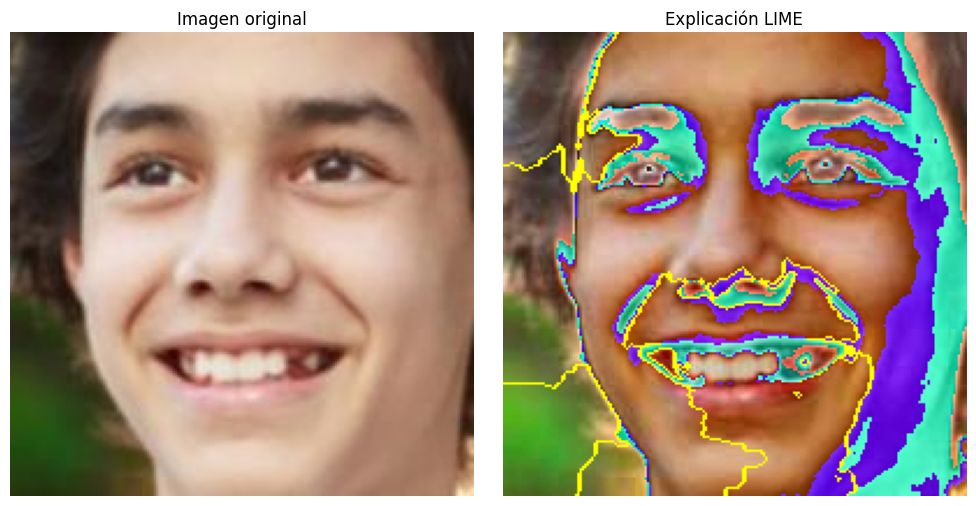

In [13]:
lime_explanation(
    imagen_original=imagen_np,              # Imagen original en formato numpy (H, W, C)
    imagen_lime=imagen,                     # Imagen a explicar (puede ser un tensor o PIL)
    modelo=agenteDW.modeloRaza,            # Modelo a utilizar (en este caso, el modelo de género)
    device=device,                          # Dispositivo donde se encuentra el modelo (cpu o cuda)
    transform=transform,                    # Transformación para preprocesar las imágenes
    task_type='classification',             # Especificamos que es una tarea de clasificación
    num_samples=1000                        # Número de muestras para generar la explicación
)


Realizamos la predicción de la edad con este modelo y observamos que es bastante precisa, ya que la edad real es 10 y el modelo predice 10,68.

In [18]:
prediccion = predict(imagen, modelo=agenteDW.modeloEdad, device=device,task_type="regression")
print ('La prediccion es: ', prediccion)

La prediccion es:  [10.688887]


Generamos la explicación para este modelo empleando de nuevo esta misma instancia para la categoría de edad.

100%|██████████| 1000/1000 [00:03<00:00, 320.04it/s]


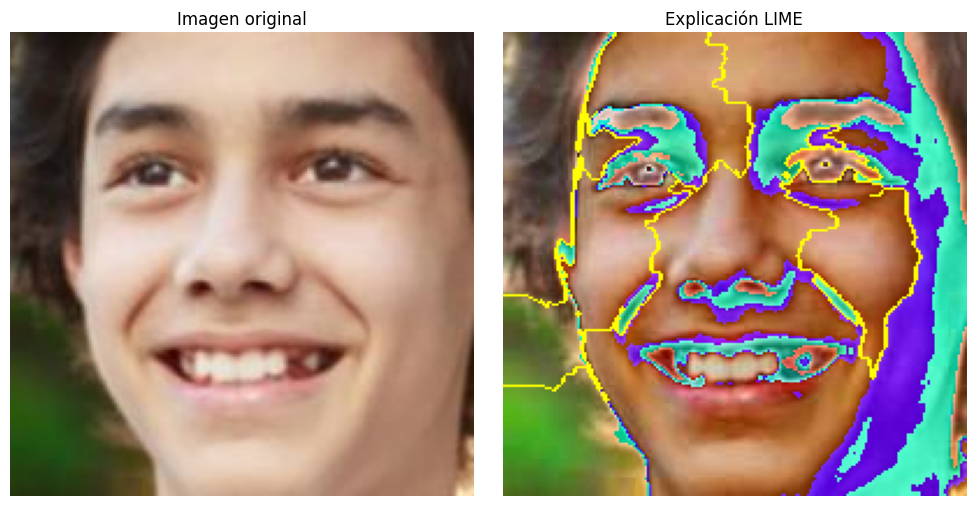

In [32]:
lime_explanation(
    imagen_original=imagen_np,              # Imagen original en formato numpy (H, W, C)
    imagen_lime=imagen,                     # Imagen a explicar (puede ser un tensor o PIL)
    modelo=agenteDW.modeloEdad,            # Modelo a utilizar (en este caso, el modelo de género)
    device=device,                          # Dispositivo donde se encuentra el modelo (cpu o cuda)
    transform=transform,                    # Transformación para preprocesar las imágenes
    task_type='regression',             # Especificamos que es una tarea de clasificación
    num_samples=1000                        # Número de muestras para generar la explicación
)


## 2. Modelo Lola Lolita

Ahora generaremos explicaciones para las categorías de edad, género y raza utilizando este modelo basado en una red convolucional, empleando nuevamente la instancia mencionada previamente.

Predecimos el género mediante el modelo y observamos que la predicción es correcta.

In [11]:
clase = predict(imagen, modelo=agenteLL.modeloGenero, device=device, task_type="classification")
print ('La prediccion es la clase: ', GENERO[clase])

La prediccion es la clase:  Hombre


Generamos la explicación correspondiente.

100%|██████████| 1000/1000 [00:10<00:00, 97.18it/s]


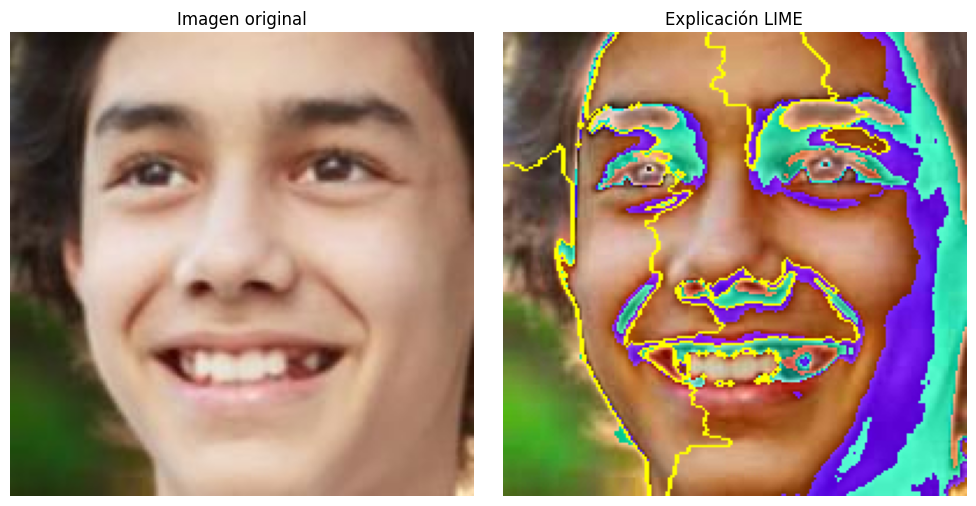

In [12]:
lime_explanation(
    imagen_original=imagen_np,              # Imagen original en formato numpy (H, W, C)
    imagen_lime=imagen,                     # Imagen a explicar (puede ser un tensor o PIL)
    modelo=agenteLL.modeloGenero,            # Modelo a utilizar (en este caso, el modelo de género)
    device=device,                          # Dispositivo donde se encuentra el modelo (cpu o cuda)
    transform=transform,                    # Transformación para preprocesar las imágenes
    task_type='classification',             # Especificamos que es una tarea de clasificación
    num_samples=1000                        # Número de muestras para generar la explicación
)


Realizamos la predicción y observamos que clasifica correctamente la raza ya que su clasificación real es "Otros".

In [28]:
clase = predict(imagen, modelo=agenteLL.modeloRaza, device=device,task_type="classification")
print ('La prediccion es la clase: ', RAZA[clase])

La prediccion es la clase:  Otros


Generamos la explicación correspondiente.

100%|██████████| 1000/1000 [00:10<00:00, 93.63it/s]


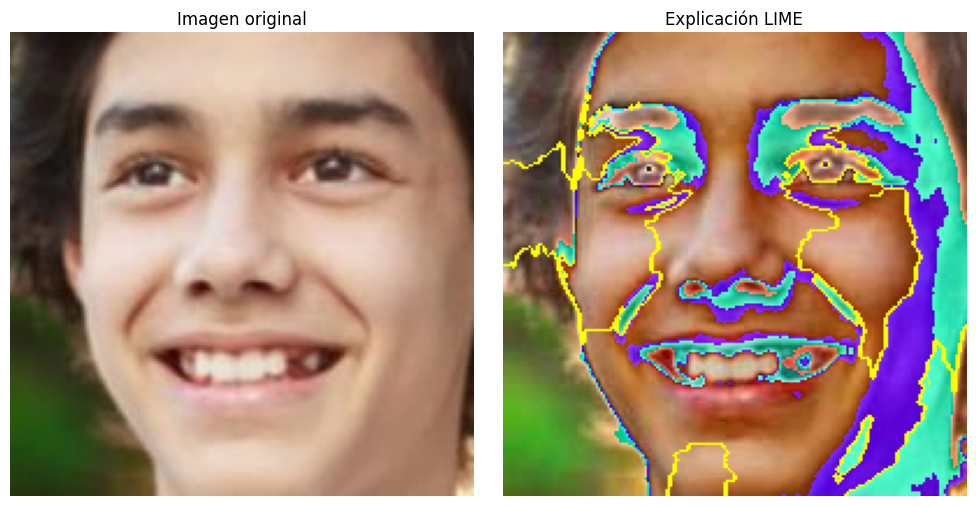

In [13]:
lime_explanation(
    imagen_original=imagen_np,              # Imagen original en formato numpy (H, W, C)
    imagen_lime=imagen,                     # Imagen a explicar (puede ser un tensor o PIL)
    modelo=agenteLL.modeloRaza,            # Modelo a utilizar (en este caso, el modelo de género)
    device=device,                          # Dispositivo donde se encuentra el modelo (cpu o cuda)
    transform=transform,                    # Transformación para preprocesar las imágenes
    task_type='classification',             # Especificamos que es una tarea de clasificación
    num_samples=1000                        # Número de muestras para generar la explicación
)


Realizamos la predicción de la edad para esta instancia y vemos que es bastante precisa, ya que la edad real es 10, mientras que el modelo predice 11,17.

In [14]:
clase = predict(imagen, modelo=agenteLL.modeloEdad, device=device,task_type="regression")
print ('La prediccion es : ', clase)

La prediccion es :  [11.175988]


Generamos la explicación para la categoría de edad.

100%|██████████| 1000/1000 [00:11<00:00, 88.93it/s]


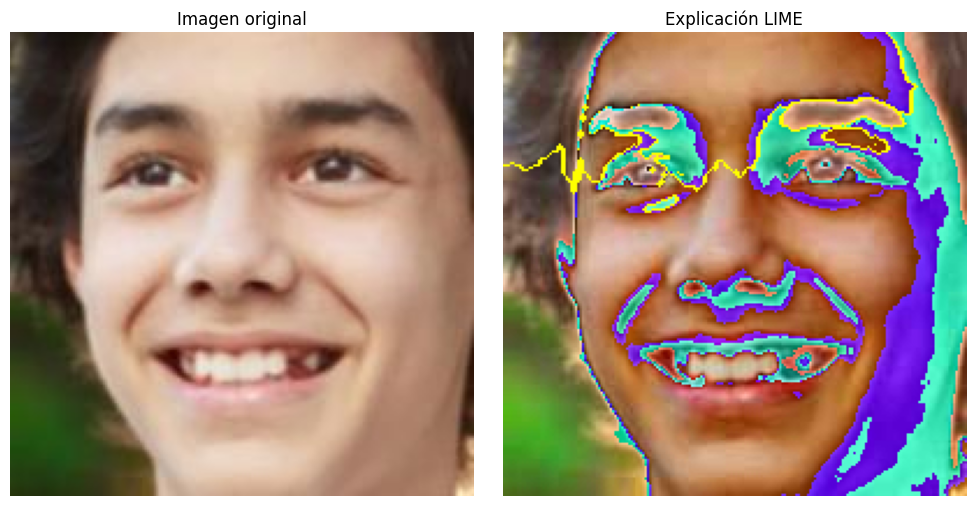

In [15]:
lime_explanation(
    imagen_original=imagen_np,              # Imagen original en formato numpy (H, W, C)
    imagen_lime=imagen,                     # Imagen a explicar (puede ser un tensor o PIL)
    modelo=agenteLL.modeloEdad,            # Modelo a utilizar (en este caso, el modelo de género)
    device=device,                          # Dispositivo donde se encuentra el modelo (cpu o cuda)
    transform=transform,                    # Transformación para preprocesar las imágenes
    task_type='regression',             # Especificamos que es una tarea de clasificación
    num_samples=1000                        # Número de muestras para generar la explicación
)


### 3. Modelo KNN

En este apartado generaremos las explicaciones correspondientes en el modelo KNN para la misma instancia.

In [69]:
importlib.reload(agente_knn)

<module 'agente_knn' from 'd:\\Universidad\\Aprendizaje-Automatico-y-Big-Data\\Practica5\\agente_knn.py'>

Ajustamos de nuevo las imágenes a un dataset que este modelo pueda manejar.

In [13]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = data.Dataset(path, transform=transform,target_transform=data.clasificarEdad)  # Pasamos las imagenes a la estructura de datos
imagen, age,gender,race = dataset.__getitem__(idx)


Realizamos la predicción y observamos que la predicción es errónea ya que el género real es hombre.

In [14]:
prediccion = agente_knn.predecir_instancia(MbappeGenero,imagen, etiqueta='genero')
print ('La prediccion es la clase: ', GENERO[prediccion])

La prediccion es la clase:  Mujer


Generamos la explicación correspondiente.

100%|██████████| 1000/1000 [21:18<00:00,  1.28s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Etiquetas disponibles en la explicación: dict_keys([np.int64(1)])


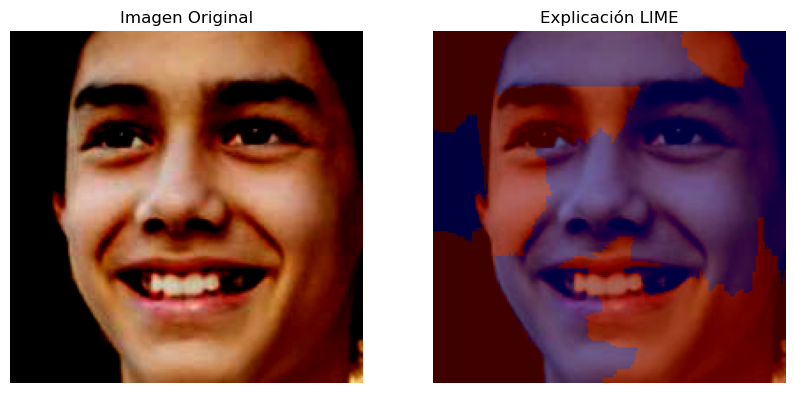

In [15]:
agente_knn.lime_explain_and_visualize(MbappeGenero, imagen, device='cpu', num_samples=1000)

Realizamos una predicción sobre la raza y observamos que esta es errónea ya que la predicción real de raza es "Otros".

In [ ]:
prediccion = agente_knn.predecir_instancia(MbappeRaza,imagen, etiqueta='raza')
print ('La prediccion es la clase: ', RAZA[prediccion])

La prediccion es la clase:  Blanco


Generamos la explicación correspondiente.

  0%|          | 0/1000 [00:00<?, ?it/s]

Etiquetas disponibles en la explicación: dict_keys([np.int64(0)])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


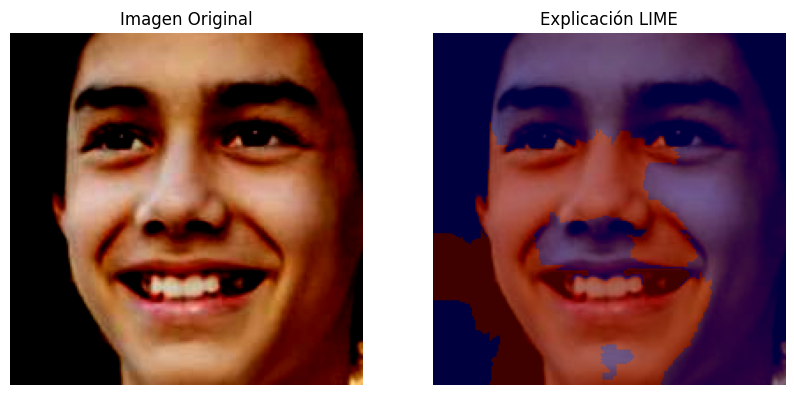

In [ ]:
agente_knn.lime_explain_and_visualize(MbappeRaza, imagen, device='cpu', num_samples=1000)

Realizamos la predicción del grupo de edad utilizando el modelo KNN y observamos que es incorrecta, ya que la edad real es de 10 años, lo que corresponde al grupo 1 (de 10 a 19 años) y no al grupo 3.

In [ ]:
prediccion = agente_knn.predecir_instancia(MbappeEdad,imagen, etiqueta='edad')
print ('La prediccion es la clase: ', prediccion)

La prediccion es la clase:  3


Generamos la correspondiente explicación.

  0%|          | 0/1000 [00:00<?, ?it/s]

Etiquetas disponibles en la explicación: dict_keys([np.int64(2)])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


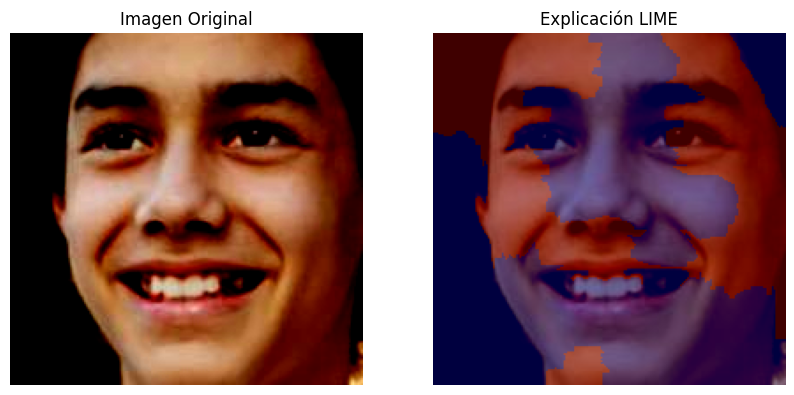

In [ ]:
agente_knn.lime_explain_and_visualize(MbappeEdad, imagen, device='cpu', num_samples=1000)

### 4. Modelo MLP

En el siguiente apartado se generarán explicaciones para la instancia previamente analizada, enfocándonos en la predicción de género, edad y raza utilizando el modelo MLP.

In [72]:
importlib.reload(agente_mlp)

<module 'agente_mlp' from 'd:\\Universidad\\Aprendizaje-Automatico-y-Big-Data\\Practica5\\agente_mlp.py'>

Transformamos el conjunto de datos en uno que el modelo pueda manejar.

In [16]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Redimensionar la imagen
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = data.Dataset(path, transform=transform)  # Pasamos las imagenes a la estructura de datos
imagen, age,gender,race = dataset.__getitem__(idx)

Realizamos la predicción de la raza y observamos que esta es errónea ya que la correcta es "Otros" y la predicción que realiza el modelo es "Asiático".

In [17]:
prediccion = agente_mlp.predecir_instancia_mlp(mlp_raza,imagen,etiqueta='raza')
print('La clase predicha es ',RAZA[prediccion])

La clase predicha es  Asiático


Generamos la explicación correspondiente.

100%|██████████| 1000/1000 [00:00<00:00, 1175.66it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


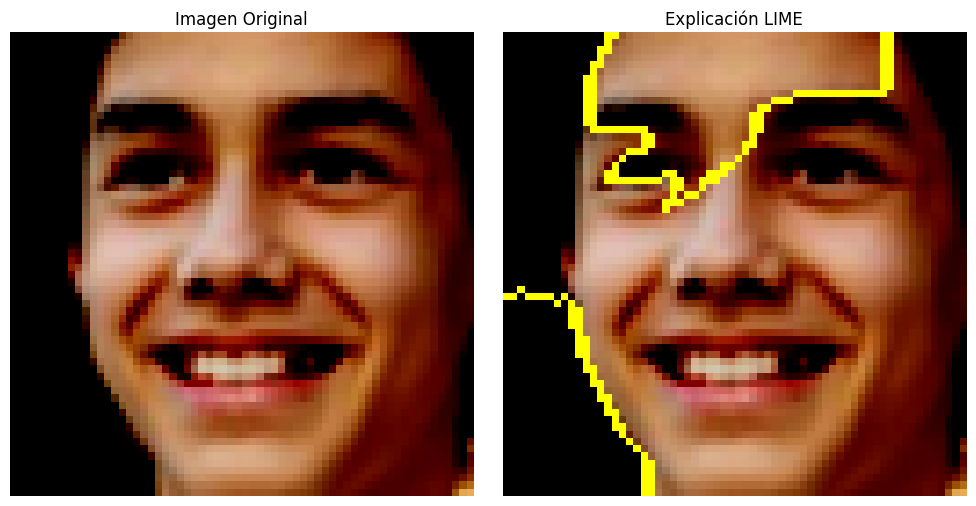

In [18]:
agente_mlp.lime_explain_and_visualize_mlp(mlp_raza, imagen, device='cpu', num_samples=1000)

Realizamos la predicción del grupo de edad y observamos que esta es correcta ya que el grupo es el 1 (de 10 a 19 años).

In [77]:
prediccion = agente_mlp.predecir_instancia_mlp(mlp_edad,imagen,etiqueta='edad')
print('La clase predicha es ',prediccion)

La clase predicha es  1


Generamos la explicación correspondiente.

100%|██████████| 1000/1000 [00:01<00:00, 972.09it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


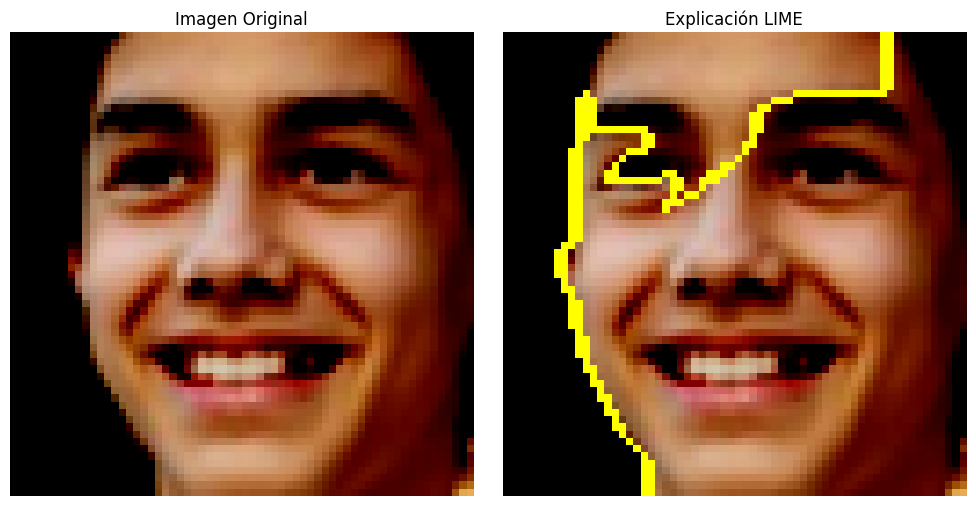

In [19]:
agente_mlp.lime_explain_and_visualize_mlp(mlp_edad, imagen, device='cpu', num_samples=1000)

Realizamos la predicción del género y observamos que esta es correcta.

In [20]:
prediccion = agente_mlp.predecir_instancia_mlp(mlp_genero,imagen,etiqueta='genero')
print('La clase predicha es ',GENERO[prediccion])

La clase predicha es  Hombre


Generamos la explicación correspondiente.

100%|██████████| 1000/1000 [00:00<00:00, 1016.42it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


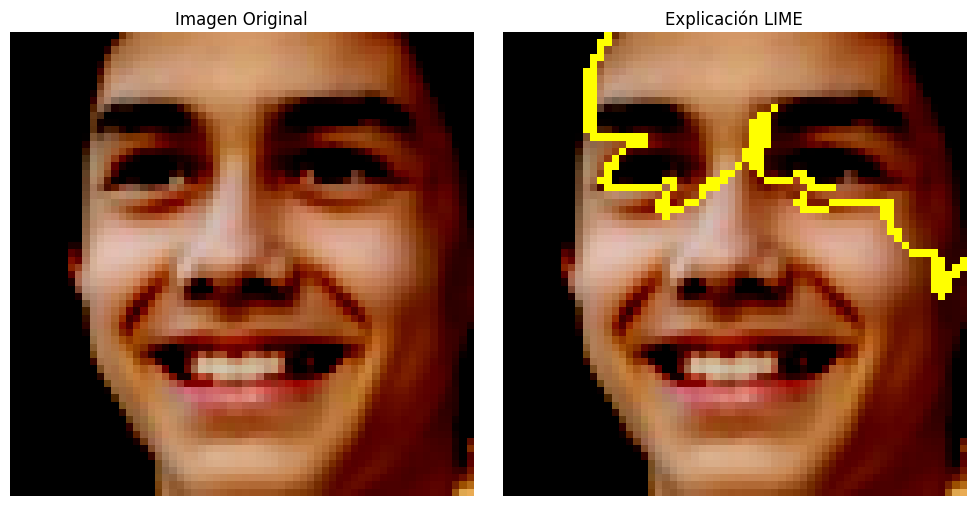

In [21]:
agente_mlp.lime_explain_and_visualize_mlp(mlp_genero, imagen, device='cpu', num_samples=1000)

Las conclusiones y la interpretación de las explicaciones se encontrarán en la memoria.